In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from scipy import io
from neurodsp import spectral
import os
import datetime
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
from fooof.funcs import fit_fooof_group_3d, combine_fooofs
import numpy as np
from scipy import signal
import sys
import pandas as pd

sys.path.append('../')
import utils
C_KEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
basepath = '/Users/rdgao/Documents/data/CRCNS/fcx1/'
rec_dirs = [f for f in np.sort(os.listdir(basepath)) if os.path.isdir(basepath+f)]
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/'
#[print(i,f) for i,f in enumerate(rec_dirs)];

# Processing

In [544]:
cur_rec = 13
print(rec_dirs[cur_rec])
ephys_data = io.loadmat(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_ephys.mat', squeeze_me=True)
behav_data = pd.read_csv(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_wakesleep.csv', index_col=0)
# get some params
num_chan, num_samp = ephys_data['lfp'].shape
fs = ephys_data['fs']
ephys_data['t_lfp'] = np.arange(0,nsamp)/fs
elec_region = np.unique(ephys_data['elec_regions'])[0]
print(ephys_data['elec_regions'][0])

Bogey_012615
mPFC


# --- LFP ANALYSIS ---

# Compute LFP PSD

In [384]:
# get subset of behavior that marks wake and sleep
behav_sub = behav_data[behav_data['Label'].isin(['Wake', 'Sleep'])]

# name, nperseg, noverlap, f_range, outlier_pct
p_configs = [['1sec', int(fs), int(fs/2), [0., 200.], 5],
                ['5sec', int(fs*5), int(fs*4), [0., 200.], 5]]

p_cfg = ['10sec', int(fs*10), int(fs*8), [0., 120.], 5]
p_cfg = p_configs[1]
print(p_cfg)
nperseg, noverlap, f_range, outlier_pct = p_cfg[1:]

psd_mean, psd_med,  = [], []
for ind, cur_eps in behav_sub.iterrows():
    # find indices of LFP that correspond to behavior
    lfp_inds = np.where(np.logical_and(ephys_data['t_lfp']>=cur_eps['Start'],ephys_data['t_lfp']<cur_eps['End']))[0]    

    # compute mean and median welchPSD
    p_squished = spectral.compute_spectrum(ephys_data['lfp'][:,lfp_inds], ephys_data['fs'], method='welch',avg_type='mean', nperseg=nperseg, noverlap=noverlap, f_range=f_range, outlier_pct=outlier_pct)
    f_axis, cur_psd_mean = p_squished[0,:], p_squished[1::2,:] # work-around for ndsp currently squishing together the outputs
    p_squished = spectral.compute_spectrum(ephys_data['lfp'][:,lfp_inds], ephys_data['fs'], method='welch',avg_type='median', nperseg=nperseg, noverlap=noverlap, f_range=f_range, outlier_pct=outlier_pct)
    f_axis, cur_psd_med = p_squished[0,:], p_squished[1::2,:]

    # append to list
    psd_mean.append(cur_psd_mean)
    psd_med.append(cur_psd_med)    

# collect, stack, and save out
psd_mean, psd_med, behav_info = np.array(psd_mean),np.array(psd_med),np.array(behav_sub)
save_dict = dict((name,eval(name)) for name in ['f_axis','psd_mean', 'psd_med','nperseg','noverlap','fs','outlier_pct', 'behav_info', 'elec_region'])

['5sec', 6250, 5000, [0.0, 200.0], 5]


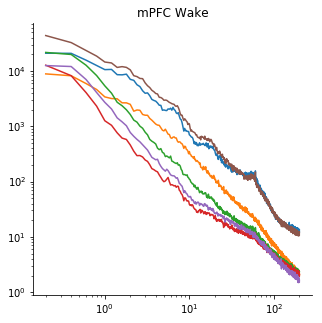

In [385]:
block = 0
p_cur = 'psd_med'
plt.figure(figsize=(5,5))
plt.loglog(save_dict['f_axis'], save_dict[p_cur][block,:,:].T)
plt.title(elec_region+' '+behav_sub.iloc[block]['Label']);
utils.remove_spines(plt.gca())

# FOOOF

In [477]:
# load precomputed PSDs
psd_path = result_basepath + rec_dirs[cur_rec] + '/psd/'
fooof_settings = [['knee', 2, (0.2,120)],
         ['fixed', 4, (0.1,120)],
         ['fixed', 2, (0.1,10)],
         ['fixed', 2, (30,55)]]

psd_win = ['1sec/', '5sec/'][1]
psd_folder = psd_path+psd_win
psd_data = np.load(psd_folder+'psds.npz')
#psd_data = save_dict
psd_mode = ['psd_mean', 'psd_med'][1]
fg_all=[]
for f_s in fooof_settings:
    fg = FOOOFGroup(aperiodic_mode=f_s[0], max_n_peaks=f_s[1])
    fgs = fit_fooof_group_3d(fg, psd_data['f_axis'], psd_data[psd_mode], freq_range=f_s[2])
    fg_all.append(combine_fooofs(fgs))

Running FOOOFGroup across 8 power spectra.
Running FOOOFGroup across 8 power spectra.
Running FOOOFGroup across 8 power spectra.
Running FOOOFGroup across 8 power spectra.
Running FOOOFGroup across 8 power spectra.
Running FOOOFGroup across 8 power spectra.
Running FOOOFGroup across 8 power spectra.
Running FOOOFGroup across 8 power spectra.


(2, 8, 1001)


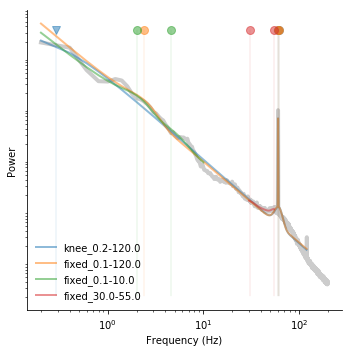

In [478]:
print(psd_data[psd_mode].shape)
chan = 4
psds = np.reshape(psd_data[psd_mode], (-1, len(psd_data['f_axis'])))
plt.figure(figsize=(5,5))
utils.plot_psd_fits(psd_data['f_axis'], psds, chan, fg_all, ['%s_%.1f-%.1f'%(f_s[0],f_s[2][0],f_s[2][1]) for f_s in fooof_settings])

# --- SPIKE ANALYSIS ---

# Pool spikes based on cell type and shank

In [545]:
# NOTE that all this had to be done because I was an idiot and 
# organized the spikeinfo table and spikes in some dumb way

# make spike info into df and access based on cell, and add end time
df_spkinfo = pd.DataFrame(ephys_data['spike_info'], columns=ephys_data['spike_info_cols'])
df_spkinfo.insert(len(df_spkinfo.columns)-1, 'spike_start_ind', np.concatenate(([0], df_spkinfo['num_spikes_cumsum'].iloc[:-1].values)))
df_spkinfo.rename(columns={'num_spikes_cumsum': 'spike_end_ind'}, inplace=True)

# this is now a list of N arrays, where N is the number of cells
#    now we can aggregate arbitrarily based on cell index
spikes_list = utils.spikes_as_list(ephys_data['spiketrain'], df_spkinfo)

# pooling across populations from the same shanks
df_spkinfo_pooled = df_spkinfo.copy()
for g_i, g in df_spkinfo.groupby(['shank', 'cell_EI_type']):
    # super python magic that collapses all the spikes of the same pop on the same shank into one array
    spikes_list.append(np.sort(np.hstack([spikes_list[c_i] for c_i, cell in g.iterrows()])))
    # update spike info dataframe
    df_pop = pd.DataFrame({'shank': g['shank'].head(1),
                           'cell_EI_type': g['cell_EI_type'].head(1), 
                           'num_spikes': g['num_spikes'].sum(),
                           'cell_id': 0 })
    df_spkinfo_pooled = df_spkinfo_pooled.append(df_pop, ignore_index=True)

# pooling across entire recording
for g_i, g in df_spkinfo.groupby(['cell_EI_type']):
    spikes_list.append(np.sort(np.hstack([spikes_list[c_i] for c_i, cell in g.iterrows()])))
    df_pop = pd.DataFrame({'shank': 0,
                           'cell_id': 0,
                           'cell_EI_type': g['cell_EI_type'].head(1), 
                           'num_spikes': g['num_spikes'].sum()})
    df_spkinfo_pooled = df_spkinfo_pooled.append(df_pop, ignore_index=True)

# plot some ISI histograms

Wake 45


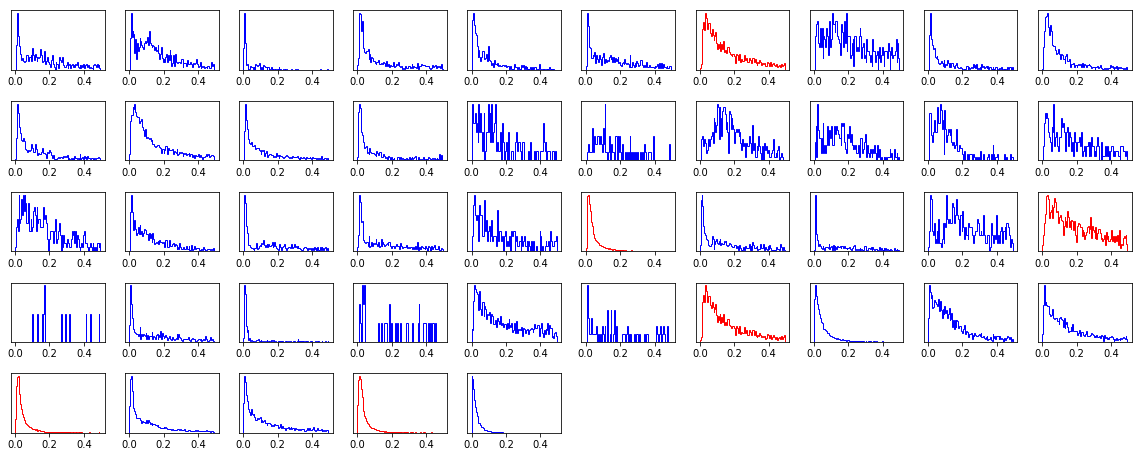

In [546]:
cur_eps = behav_sub.iloc[0]
print(cur_eps['Label'], len(spikes_list))
plt.figure(figsize=(16,10))
for cell, spikes in enumerate(spikes_list):
    plt.subplot(8,10,cell+1)
    spikes_eps = spikes[np.logical_and(spikes>=cur_eps['Start'],spikes<cur_eps['End'])]
    plt.hist(np.diff(spikes_eps), bins = np.arange(0,0.5,0.005), normed=True, histtype='step',
             color='b' if df_spkinfo_pooled['cell_EI_type'].iloc[cell]==1 else 'r')
    plt.yticks([])

plt.tight_layout()

# binarize spikes and compute PSDs
skip if using pre-computed PSDs

In [401]:
# individual cells
dt, win_len = 0.005, 2.
fs_spk = 1/dt
nperseg = int(win_len/dt)
noverlap = int(nperseg*4/5)

behav_sub = behav_data[behav_data['Label'].isin(['Wake', 'Sleep'])].reset_index()
num_block, num_cell = len(behav_sub), len(spikes_list)
psd_spikes = np.zeros((num_block, num_cell, int(nperseg/2+1)))
for cell, spikes in enumerate(spikes_list):
    print(cell,end='|')
    for block, cur_eps in behav_sub.iterrows():
        spikes_eps = spikes[np.logical_and(spikes>=cur_eps['Start'],spikes<cur_eps['End'])]
        t_spk, spikes_binned = utils.bin_spiketrain(spikes_eps, dt, cur_eps[['Start', 'End']])
        f_spk, psd_spikes[block, cell, :] = spectral.compute_spectrum(spikes_binned, fs_spk, nperseg=nperseg, noverlap=noverlap)

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|

# Plot spike PSDs from shank aggregates

10


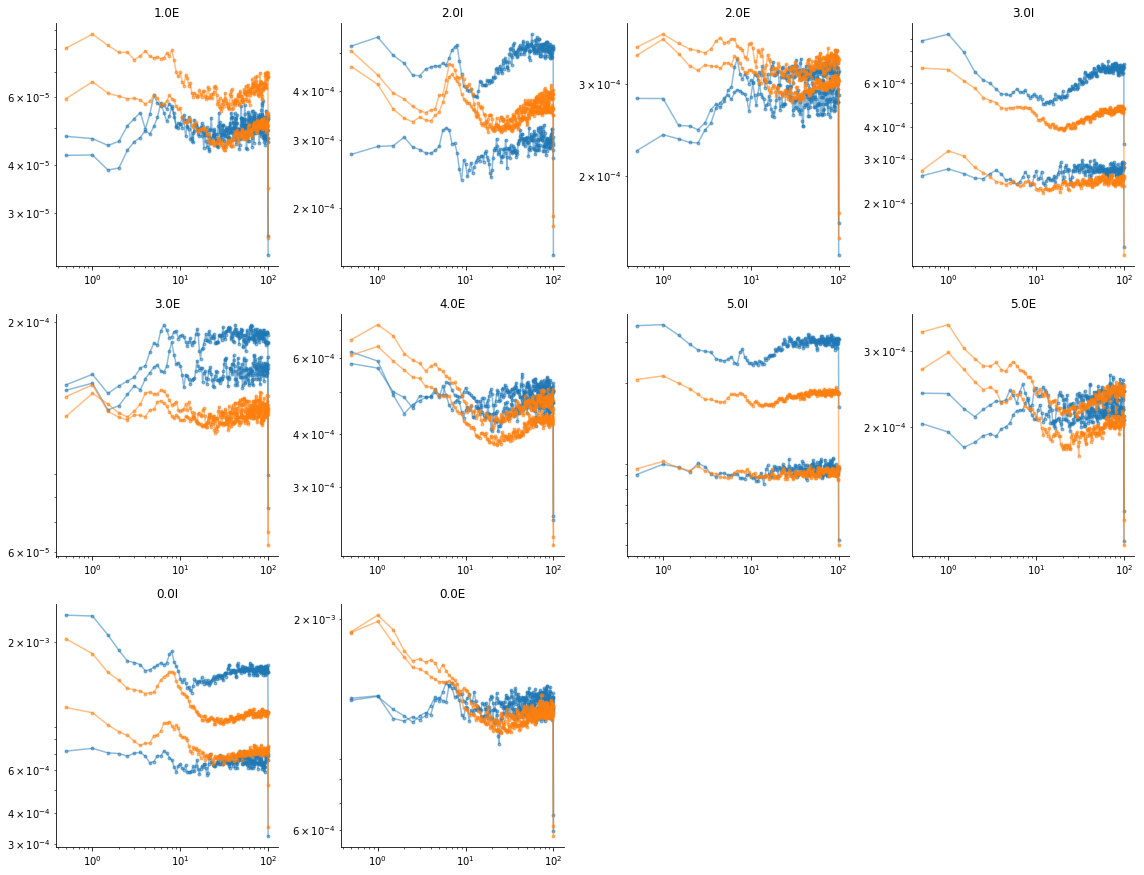

In [402]:
df_pops = df_spkinfo_pooled[df_spkinfo_pooled['cell_id']==0]
print(len(df_pops))
f_ind_end = 500
plt.figure(figsize=(16,16))
for cell, cell_info in df_pops.iterrows():
    plt.subplot(4,4,cell-df_pops.head(1).index.values+1)
    plt.loglog(f_spk[1:f_ind_end], np.squeeze(psd_spikes[:int(num_block/2),cell,1:f_ind_end]).T, '.-', color=C_KEYS[0], alpha=0.5);
    plt.loglog(f_spk[1:f_ind_end], np.squeeze(psd_spikes[int(num_block/2):,cell,1:f_ind_end]).T, '.-', color=C_KEYS[1], alpha=0.5);
    utils.remove_spines(plt.gca());
    plt.title(cell_info['shank'].astype(str) + ('E' if cell_info['cell_EI_type']==1 else 'I') )
    plt.yticks([], '');

plt.tight_layout()

# FOOOF Spike PSDs

In [579]:
# load precomputed PSDs
psd_path = result_basepath + rec_dirs[cur_rec] + '/psd_spikes/'
fooof_settings = [['knee', 2, (0.2,120)],
         ['fixed', 4, (0.1,120)],
         ['fixed', 2, (0.1,10)],
         ['fixed', 2, (30,55)]]

psd_win = ['2sec/', '5sec/'][0]
psd_folder = psd_path+psd_win
psd_spikes_data = np.load(psd_folder+'psds.npz')
f_axis_spk = psd_spikes_data['f_axis']
df_spkinfo_pooled = pd.read_csv(psd_path+'/spike_info.csv', index_col=0)

In [580]:
df_pops = df_spkinfo_pooled[df_spkinfo_pooled['cell_id']==0]
#df_pops = df_spkinfo_pooled
psd_spikes = psd_spikes_data['psd_mean']
psd_spk_pops = psd_spikes[:,df_pops.index.values,:]

fgs_all = []
for f_s in fooof_settings_spks:
    print('---')
    fg_spks = FOOOFGroup(aperiodic_mode=f_s[0], max_n_peaks=f_s[1], peak_width_limits=(5,20))
    fg_spks_all = fit_fooof_group_3d(fg_spks, f_axis_spk, psd_spk_pops, freq_range=f_s[2]);    
    #fgs_all.append(combine_fooofs(fg_spks_all))
    fgs_all.append(fg_spks_all)


---
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
---
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
---
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
---
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spectra.
Running FOOOFGroup across 9 power spec

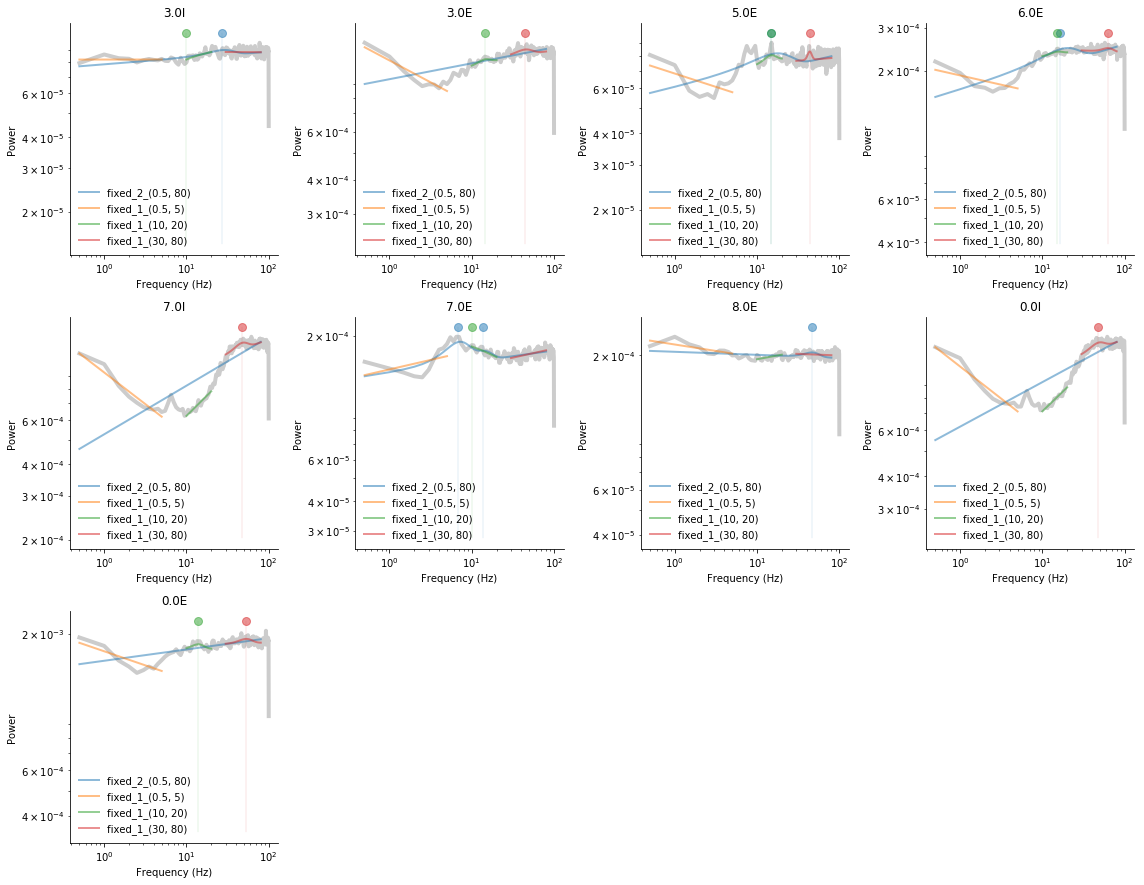

In [581]:
block=1
fgs_block = [fgs[block] for fgs in fgs_all]
f_ind_end = 400
plt.figure(figsize=(16,16))
for cell, cell_info in df_pops.iterrows():
    chan = cell-df_pops.head(1).index.values
    plt.subplot(4,4,chan+1)
    utils.plot_psd_fits(f_axis_spk[:f_ind_end], np.squeeze(psd_spk_pops[block,:,:f_ind_end]), chan, fgs_block, ['_'.join([str(s) for s in f_s]) for f_s in fooof_settings_spks])
    plt.title(cell_info['shank'].astype(str) + ('E' if cell_info['cell_EI_type']==1 else 'I') )


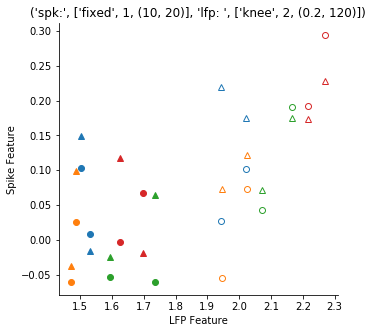

In [474]:
lfp_ff_setting = 0
spk_ff_setting = 2
plt.figure(figsize=(5,5))
for block in range(num_block)[0:4]:
    lfp_feat = fg_all[lfp_ff_setting].get_params('aperiodic_params')[block*num_chan:(block+1)*num_chan]
    lfp_feat = lfp_feat[:,-1] # exponent
    #_, lfp_feat = utils.convert_knee_val(lfp_feat[:,1],lfp_feat[:,2]) # time constant
    
    spks_feat = fgs_all[spk_ff_setting][block].get_params('aperiodic_params')
    spks_feat = spks_feat[:,-1] # exponent
    #_, spks_feat = utils.convert_knee_val(spks_feat[:,1],spks_feat[:,2]) # time constant
    
    for cell, cell_info in df_pops.reset_index().iterrows():
        if cell_info['shank']:
            lfp_ind = int(np.where(ephys_data['elec_shank_map'][:,0]==cell_info['shank'])[0])
            plt.plot(lfp_feat[lfp_ind], spks_feat[cell], 
                     '^' if cell_info['cell_EI_type']==1 else 'o', 
                     color=C_KEYS[lfp_ind],
                     mfc = 'w' if behav_sub.iloc[block]['Label']=='Sleep' else None)

#plt.xscale('log'); 
#plt.yscale('log')
utils.remove_spines(plt.gca()); 
plt.xlabel('LFP Feature'); plt.ylabel('Spike Feature')            
plt.title(('spk:', fooof_settings_spks[spk_ff_setting], 'lfp: ', fooof_settings[lfp_ff_setting]));

In [403]:
dt, win_len, f_range = 0.002, 1., (0.1, 150)
spike_segs = np.append(np.array([0]),ephys_data['spike_info'][:,4])
cell = 1
spks = ephys_data['spiketrain'][spike_segs[cell]:spike_segs[cell+1]]

In [404]:
%%time
t_spk, spk_binned = bin_spiketrain(spks, dt)
nperseg = 1+2*win_len/dt
noverlap = nperseg*4/5
f_spk, psd_spk = spectral.compute_spectrum(spk_binned, fs_spk, nperseg=nperseg, noverlap=noverlap)

CPU times: user 1.68 s, sys: 927 ms, total: 2.61 s
Wall time: 1.78 s


In [405]:
# %%time
# t_ac, ac = acf_events(spks,win_len,dt)
# # well this is slow as shit
# f_ac = np.fft.fftfreq(ac.shape[-1], dt)
# psd_ac = np.squeeze(np.abs(np.fft.fft(ac, norm='ortho')))[f_ac>=0]
# f_ac = f_ac[f_ac>=0]

CPU times: user 2min 49s, sys: 2.77 s, total: 2min 52s
Wall time: 1min 35s


In [406]:
# AC returns winlen*2/dt+1 samples, at sampling interval of 1/dt
# PSD returns nperseg samples, at sampling interval of 1/dt
print((win_len*2/dt+1, len(f_ac), f_ac[1]))
print((nperseg, len(f_spk),f_spk[1]))

(1001.0, 501, 0.49950049950049946)
(1001.0, 501, 0.49950049950049946)


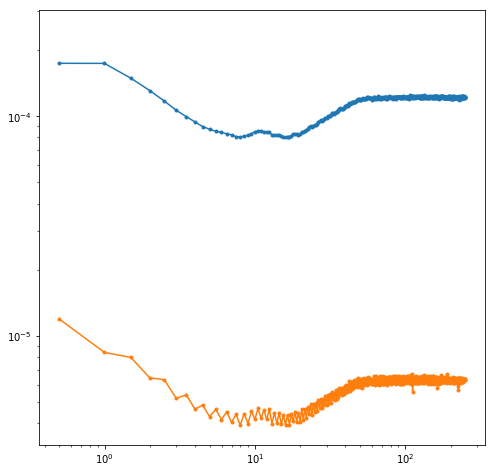

In [407]:
plt.figure(figsize=(8,8))
plt.loglog(f_spk, psd_spk, '.-')
plt.loglog(f_ac, psd_ac/5e3, '.-')

(1001,)


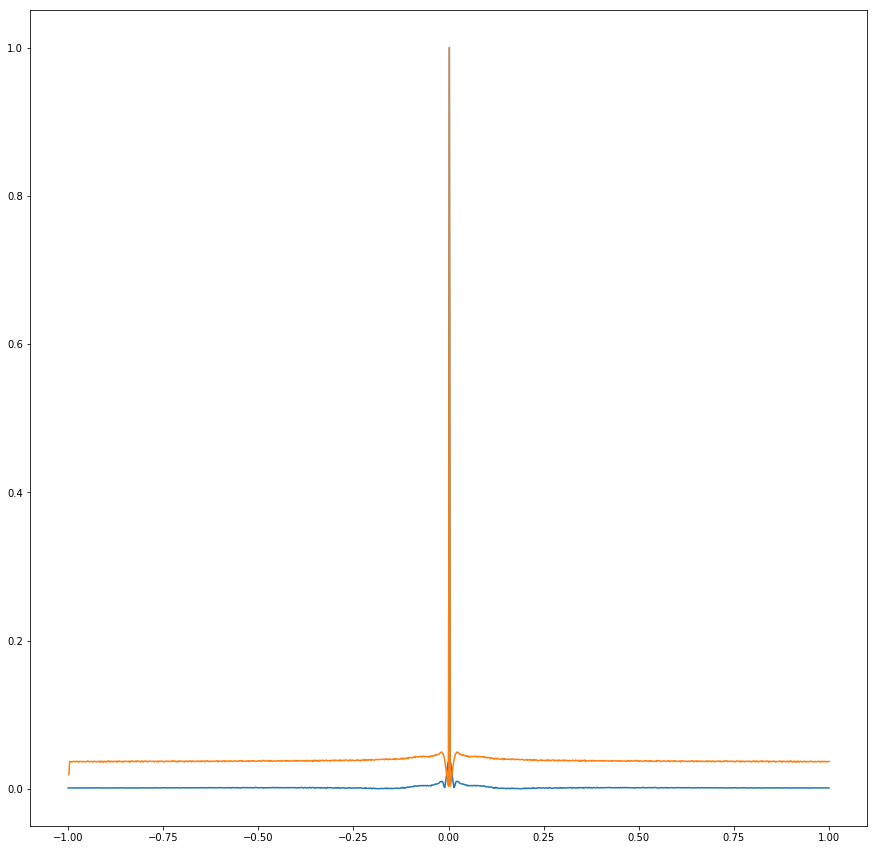

In [410]:
ac_psd = np.abs(np.fft.ifft(np.concatenate((psd_spk, psd_spk[1:][::-1]))))
ac_psd = np.fft.ifftshift(ac_psd/ac_psd[0])
print(ac_psd.shape)

plt.figure(figsize=(15,15))
plt.plot(t_ac, ac_psd.real)
plt.plot(t_ac[1:], ac[:-1])
#plt.xlim([-0.2 ,0.2])

In [638]:
# individual cells
t_max, dt = 2., 0.005

spike_segs = np.append(np.array([0]),ephys_data['spike_info'][:,4])
behav_sub = behav_data[behav_data['Label'].isin(['Wake', 'Sleep'])].reset_index()
ac_all = np.zeros((len(behav_sub), len(spike_segs)-1, int(2*t_max/dt)+1))

for cell in range(len(spike_segs)-1):
    print(cell,end='|')
    spks = ephys_data['spiketrain'][spike_segs[cell]:spike_segs[cell+1]]
    for ind, cur_eps in behav_sub.iterrows():
        spks_eps = spks[np.logical_and(spks>=cur_eps['Start'],spks<cur_eps['End'])]
        t_ac, ac_all[ind, cell,:] = acf_events(spks_eps, t_max, dt, norm=True)

f_ac = np.fft.fftfreq(ac_all.shape[-1], dt)
psd = np.abs(np.fft.fft(ac_all*signal.hann(ac_all.shape[-1])[None,None,:]))

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|

In [647]:
# population of E, I, and all cells
#ephys_data['spike_info']

In [648]:
spks = np.sort(ephys_data['spiketrain'])
ac_pop = np.zeros((len(behav_sub), 3, int(2*t_max/dt)+1))
for ind, cur_eps in behav_sub.iterrows():
    spks_eps = spks[np.logical_and(spks>=cur_eps['Start'],spks<cur_eps['End'])]
    t_ac, ac_pop[ind,0,:] = acf_events(spks_eps, t_max, dt, norm=True)


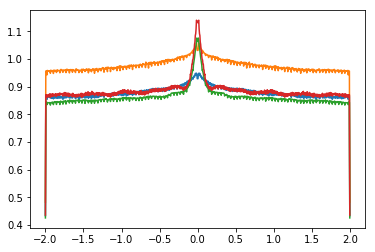

In [649]:
#plt.subplot(1,2,1)
plt.plot(t_ac[t_ac!=0],ac_pop[:,0,t_ac!=0].T)

99.87515605493134


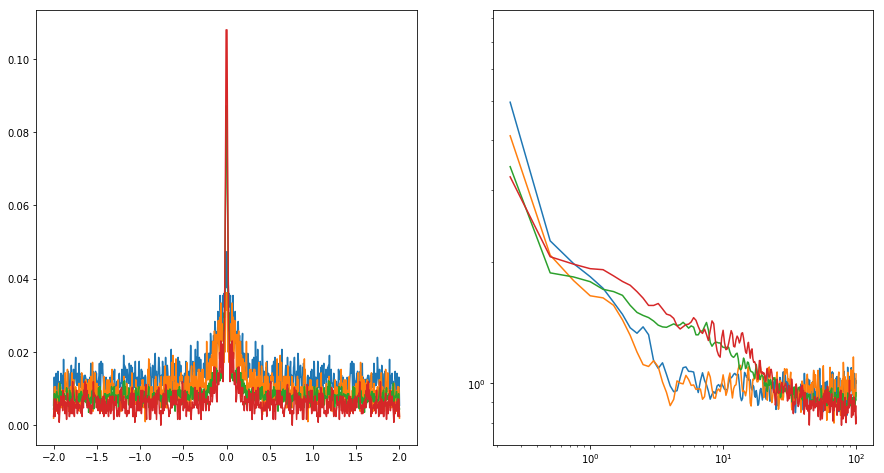

In [643]:
psd_win = np.abs(np.fft.fft(ac_all*signal.hann(ac_all.shape[-1])[None,None,:]))
psd = np.abs(np.fft.fft(ac_all))
cell= 44
print(max(f_ac))
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(t_ac[t_ac!=0],ac_all[:,cell,t_ac!=0].T)
plt.subplot(1,2,2)
#plt.loglog(f_ac, psd[:,cell,:].T, '-')
plt.loglog(f_ac, psd_win[:,cell,:].T, '-')

In [ ]:
fit_fooof_group_3d()

In [228]:
spks = np.sort(ephys_data['spiketrain'])
spks.max()*1000
# this is too goddamn slow
spks = np.sort(ephys_data['spiketrain'])
t_ac, ac = acf_events(spks, t_max, dt)
f_ac = np.fft.fftfreq(len(ac), dt)
psd = np.abs(np.fft.fft(ac))**2
ac[t_ac==0]=0
plt.subplot(1,2,1)
plt.plot(t_ac,ac)
plt.subplot(1,2,2)
plt.loglog(f_ac[1:400], psd[1:400])

KeyboardInterrupt: 

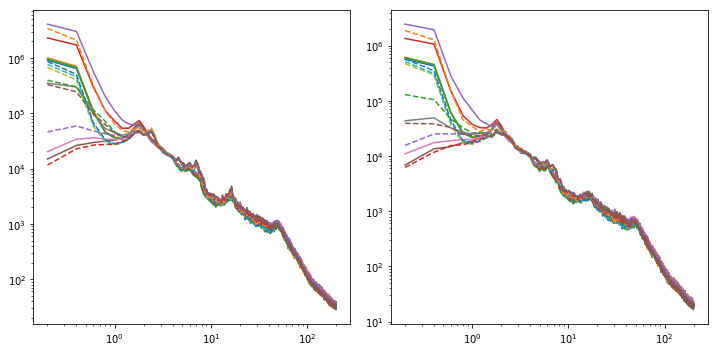

In [158]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.loglog(f_axis, psd_mean[0].T)
plt.loglog(f_axis, psd_mean[1].T,'--')

plt.subplot(1,3,2)
plt.loglog(f_axis, psd_med[0].T)
plt.loglog(f_axis, psd_med[1].T,'--')

plt.tight_layout()

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

KeyboardInterrupt: 

In [660]:
fg_all.save(file_path='/Users/rdgao/Desktop/', save_results=True, save_settings=True)
fg = FOOOFGroup()
fg.load('/Users/rdgao/Desktop/FOOOFGroup_results.json')
fg.freqs

In [ ]:
cur_rec=0
data = io.loadmat(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_combined.mat', squeeze_me=True)
pd.DataFrame(data['spike_info'], columns=data['spike_info_cols'])

In [39]:
basepath = '/Users/rdgao/Documents/data/MNI_rest/'
datafile = basepath + 'WakefulnessMatlabFile.mat'
data_dict = io.loadmat(datafile, squeeze_me = True)
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest/'

In [40]:
print(data_dict.keys())
fs = data_dict['SamplingFrequency']
data = data_dict['Data']
sig_len, nchans = data.shape

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])


In [41]:
def compute_spectrum_w_holes(data, fs, window, nperseg, noverlap):
    f_axis,t_axis,spg = signal.spectrogram(data, fs, 'hann', nperseg, noverlap)
    psd_mean = spg[:,~np.all(spg==0, axis=0)].mean(1)
    psd_median = np.median(spg[:,~np.all(spg==0, axis=0)],axis=1)
    return f_axis, psd_mean, psd_median

def compute_psds_whole(data, fs, nperseg, noverlap):
    # compute psd and toss slices with holes
    psd_mean = np.zeros((int(nperseg/2+1), nchans))
    psd_med = np.zeros((int(nperseg/2+1), nchans))
    for chan in range(nchans):
        f_axis, psd_mean[:,chan], psd_med[:,chan] = compute_spectrum_w_holes(data[:,chan], fs, 'hann', nperseg, noverlap)
    return f_axis, psd_mean, psd_med

# Compute PSDs
#### 1s window (1Hz)

In [5]:
nperseg, noverlap = int(fs), int(fs/2)
f_axis, psd_mean, psd_med = compute_psds_whole(data, fs, nperseg, noverlap)
saveout_path = utils.makedir(result_basepath, 'psd/1sec/', timestamp=False)
np.savez(saveout_path+'psds.npz', psd_mean=psd_mean, psd_med=psd_med,
         f_axis=f_axis, nperseg=nperseg, noverlap=noverlap)

#### 5s window (0.2Hz)

In [7]:
nperseg, noverlap = int(fs*5), int(fs*4)
f_axis, psd_mean, psd_med = compute_psds_whole(data, fs, nperseg, noverlap)
saveout_path = utils.makedir(result_basepath, '/psd/5sec/', timestamp=False)
np.savez(saveout_path+'psds.npz', psd_mean=psd_mean, psd_med=psd_med,
         f_axis=f_axis, nperseg=nperseg, noverlap=noverlap)

# FOOOFing

In [30]:
fooof_settings = [['knee', 2, (2,55)],
                 ['fixed', 2, (2,55)],
                 ['fixed', 1, (1,10)],
                 ['fixed', 1, (30,55)]]

for psd_win in ['1sec/', '5sec/']:
    psd_folder = result_basepath+'/psd/'+psd_win
    psd_data = np.load(psd_folder+'psds.npz')
    for f_s in fooof_settings:
        fg = FOOOFGroup(background_mode=f_s[0], max_n_peaks=f_s[1])
        fg.fit(psd_data['f_axis'], psd_data['psd_mean'].T, freq_range=f_s[2])
        fooof_savepath = utils.makedir(psd_folder, '/fooof/', timestamp=False)
        fg.save('fg_%s_%ipks_%i-%iHz'%(f_s[0],f_s[1],f_s[2][0],f_s[2][1]), fooof_savepath, save_results=True, save_settings=True)

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too 

In [371]:
def my_fftfreqs(sig_len, fs):
    # num_k is the total (or max) wavenumber/ number of frequencies
    #   for every point in your signal, you have a wavenumber
    num_k = sig_len
    
    # positive frequencies are easy, it goes from 0 to nyquist at even spacing
    # this means that you might not actually land on f_nyquist
    pos_f = np.arange(0,fs/2,fs/num_k)
    if num_k%2:
        # num_k is odd, negative frequencies are symmetric about 0Hz
        neg_f = -pos_f[1:][::-1]
    else:
        # if num_k is even, negative frequencies are symmetric about 0Hz, plus Nyquist
        #   we take the negative of Nyquist freq to follow numpy convention
        neg_f = np.concatenate(([-fs/2], -pos_f[1:][::-1]))
    return np.concatenate((pos_f, neg_f))

def my_sft(t, sig, fs):
    # SFT stands for slow Fourier transform. Get it?
    f_axis = my_fftfreqs(len(sig), fs)
    
    # the holder array has to be initialized as complex
    SFT = np.zeros(len(sig))*1j
    for i, f in enumerate(f_axis):
        # where the magic happens
        cosine, sine = np.cos(t*2*np.pi*f), np.sin(t*2*np.pi*f)
        SFT[i] = np.dot(sig,cosine)+np.dot(sig,sine)*1.j
    
    return f_axis, SFT    

In [ ]:
# little blurb to deal with one particularly big datafile
cur_rec = 22
# load the datafile which did not save the LFP
ephys_data = io.loadmat(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_ephys.mat', squeeze_me=True)

# load the datafile that did save the LFP in hdf5 form (MAT -v7.3)
import numpy as np, h5py 
f = h5py.File(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_ephys2.mat','r')
ephys_data['lfp'] = np.array(f['lfp'].value).T

# re-save
io.savemat(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_ephys.mat', ephys_data, do_compression=True)